# PM-PR-0015 | Bank GoodCredit 

## Install necessary libraries

In [2]:
!pip install tensorflow
!pip install -q optuna

!pip install pymysql
!pip install mysql-connector

     ---------------------------------------- 0.0/11.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/11.9 MB ? eta -:--:--
     -- ------------------------------------- 0.8/11.9 MB 4.2 MB/s eta 0:00:03
     --- ------------------------------------ 1.0/11.9 MB 2.3 MB/s eta 0:00:05
     ----- ---------------------------------- 1.6/11.9 MB 2.7 MB/s eta 0:00:04
     ------- -------------------------------- 2.1/11.9 MB 2.4 MB/s eta 0:00:05
     -------- ------------------------------- 2.6/11.9 MB 2.3 MB/s eta 0:00:04
     --------- ------------------------------ 2.9/11.9 MB 2.2 MB/s eta 0:00:05
     ----------- ---------------------------- 3.4/11.9 MB 2.5 MB/s eta 0:00:04
     -------------- ------------------------- 4.2/11.9 MB 2.4 MB/s eta 0:00:04
     --------------- ------------------------ 4.7/11.9 MB 2.5 MB/s eta 0:00:03
     ------------------ --------------------- 5.5/11.9 MB 2.5 MB/s eta 0:00:03
     ------------------ --------------------- 5.5/11.9 MB 2.5 MB/s

## Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import time
from datetime import date

In [4]:
import os
import mysql.connector
import warnings
warnings.filterwarnings('ignore')

import time
from datetime import date
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from xgboost import XGBClassifier
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, average_precision_score
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import optuna
from sklearn.inspection import permutation_importance


# pd.set_option('display.max_columns', None) # To display all the columns in a dataframe
# pd.set_option('display.float_format', '{:.0f}'.format) # To display full float numbers in a dataframe
# pd.set_option('display.max_rows', None) # To display all the rows in a dataframe

## Database connection and extracting data from database

In [5]:
## connecting the database
connection=mysql.connector.connect(host='18.136.157.135',
                                  user=' dm_team1',
                                  password='DM!$Team&279@20!',
                                  database='project_banking')

In [6]:
db_tables = pd.read_sql_query('show databases',connection)
db_tables

,Database
0,information_schema
1,project_banking


In [7]:
db_tables = pd.read_sql_query('show tables',connection)
db_tables

,Tables_in_project_banking
0,Cust_Account
1,Cust_Demographics
2,Cust_Enquiry


In [8]:
df_cust_acc = pd.read_sql_query('select * from Cust_Account',connection)
df_cust_acc.head()

,dt_opened,customer_no,upload_dt,acct_type,owner_indic,opened_dt,last_paymt_dt,closed_dt,reporting_dt,high_credit_amt,...,amt_past_due,paymenthistory1,paymenthistory2,paymt_str_dt,paymt_end_dt,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount
0,10-Nov-15,12265,20-Oct-15,6,1,09-Jun-13,30-Jun-14,05-Jul-14,30-Sep-15,20900,...,,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",,01-Sep-15,01-Jul-14,,,,,
1,10-Nov-15,12265,20-Oct-15,10,1,25-May-12,06-Sep-15,,03-Oct-15,16201,...,,"""""""0000000000000000000000000000000000000000000...","""""""000000000000000000000000000XXX0000000000000...",01-Oct-15,01-Nov-12,14000,1400,,3,5603
2,10-Nov-15,12265,20-Oct-15,10,1,22-Mar-12,31-Aug-15,,30-Sep-15,41028,...,,"""""""0000000000000000000000000000000000000000000...","""""""0000000000000000000000000000000000000000000...",01-Sep-15,01-Oct-12,,,,,
3,20-Jul-15,15606,09-Jul-15,10,1,13-Jan-06,,26-Jul-07,31-Jan-09,93473,...,,"""""""1200900600600600300000000000000000000000000...",,01-Jul-07,01-Feb-06,,,,,
4,20-Jul-15,15606,09-Jul-15,6,1,18-Jan-15,05-May-15,,31-May-15,20250,...,,"""""""000000000000000""""""",,01-May-15,01-Jan-15,,,,,


In [9]:
df_cust_acc.shape

(186329, 21)

In [10]:
df_cust_demo = pd.read_sql_query('select * from Cust_Demographics',connection)
df_cust_demo.head()

,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label
0,18-Apr-15,1,13-Apr-15,Insignia,13-Apr-15,650,2,Card Setup,14,500000,...,21,R,,,0000-00-00,0,98332XXXXX,1,N,0
1,21-Apr-15,2,21-Apr-15,Insignia,21-Apr-15,760,1,Card Setup,14,1200000,...,17,R,,,0000-00-00,0,99455XXXXX,1,N,0
2,22-Apr-15,3,21-Apr-15,Insignia,21-Apr-15,774,1,Card Setup,14,700000,...,17,R,,,0000-00-00,0,98456XXXXX,1,N,0
3,25-Apr-15,4,15-Apr-15,Insignia,20-Apr-15,770,1,Card Setup,14,500000,...,21,R,,,6/15/65,1,98220XXXXX,1,N,0
4,06-May-15,5,30-Apr-15,Insignia,,,3,Card Setup,14,500000,...,13,R,,,0000-00-00,0,98111XXXXX,1,N,0


In [11]:
df_cust_demo.shape

(23896, 83)

In [12]:
df_cust_eqr = pd.read_sql_query('select * from Cust_Enquiry',connection)
df_cust_eqr.head()

,dt_opened,customer_no,upload_dt,enquiry_dt,enq_purpose,enq_amt
0,18-Apr-15,1,21-Apr-15,19-Dec-14,2,3500000
1,18-Apr-15,1,21-Apr-15,05-Mar-14,5,500000
2,18-Apr-15,1,21-Apr-15,05-Mar-14,0,50000
3,18-Apr-15,1,21-Apr-15,22-Feb-14,10,50000
4,18-Apr-15,1,21-Apr-15,11-Jun-13,10,1000


In [13]:
df_cust_eqr.shape

(413188, 6)

In [14]:
# Saving the datasets to csv file

df_cust_acc.to_csv('Cust_account.csv')
df_cust_demo.to_csv('Cust_Demographics.csv')
df_cust_eqr.to_csv('Cust_Enquiry.csv')

## Reading csv file

In [15]:
cust_acc = pd.read_csv('Cust_account.csv')
cust_demo = pd.read_csv('Cust_Demographics.csv')
cust_eqr = pd.read_csv('Cust_Enquiry.csv')

## Basic EDA

In [16]:
def basic_eda(df):
    print(f"First 5 rows of the dataframe :")
    display(df.head())

    print(f"\nDataframe Info:")
    print(df.info())

    print(f"\nStatistical Summary:")
    display(df.describe(include='all'))

    print(f"\nMissing Values:")
    print(df.isnull().sum().sort_values(ascending=False))

    print(f"\nDuplicate Rows: ")
    print(df.duplicated().sum())

    print(f"\nData Types:")
    print(df.dtypes)

    print(f"\nShape of the DataFrame:")
    print(df.shape)

In [17]:
basic_eda(cust_acc)

First 5 rows of the dataframe :


,Unnamed: 0,dt_opened,customer_no,upload_dt,acct_type,owner_indic,opened_dt,last_paymt_dt,closed_dt,reporting_dt,...,amt_past_due,paymenthistory1,paymenthistory2,paymt_str_dt,paymt_end_dt,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount
0,0,10-Nov-15,12265,20-Oct-15,6,1,09-Jun-13,30-Jun-14,05-Jul-14,30-Sep-15,...,NaN,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",NaN,01-Sep-15,01-Jul-14,NaN,NaN,NaN,NaN,NaN
1,1,10-Nov-15,12265,20-Oct-15,10,1,25-May-12,06-Sep-15,NaN,03-Oct-15,...,NaN,"""""""0000000000000000000000000000000000000000000...","""""""000000000000000000000000000XXX0000000000000...",01-Oct-15,01-Nov-12,14000.0,1400.0,NaN,3.0,5603.0
2,2,10-Nov-15,12265,20-Oct-15,10,1,22-Mar-12,31-Aug-15,NaN,30-Sep-15,...,NaN,"""""""0000000000000000000000000000000000000000000...","""""""0000000000000000000000000000000000000000000...",01-Sep-15,01-Oct-12,NaN,NaN,NaN,NaN,NaN
3,3,20-Jul-15,15606,09-Jul-15,10,1,13-Jan-06,NaN,26-Jul-07,31-Jan-09,...,NaN,"""""""1200900600600600300000000000000000000000000...",NaN,01-Jul-07,01-Feb-06,NaN,NaN,NaN,NaN,NaN
4,4,20-Jul-15,15606,09-Jul-15,6,1,18-Jan-15,05-May-15,NaN,31-May-15,...,NaN,"""""""000000000000000""""""",NaN,01-May-15,01-Jan-15,NaN,NaN,NaN,NaN,NaN



Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186329 entries, 0 to 186328
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           186329 non-null  int64  
 1   dt_opened            186329 non-null  object 
 2   customer_no          186329 non-null  int64  
 3   upload_dt            186329 non-null  object 
 4   acct_type            186329 non-null  int64  
 5   owner_indic          186329 non-null  int64  
 6   opened_dt            185874 non-null  object 
 7   last_paymt_dt        160842 non-null  object 
 8   closed_dt            77254 non-null   object 
 9   reporting_dt         186329 non-null  object 
 10  high_credit_amt      177454 non-null  float64
 11  cur_balance_amt      186329 non-null  int64  
 12  amt_past_due         876 non-null     float64
 13  paymenthistory1      186329 non-null  object 
 14  paymenthistory2      78505 non-null   object 
 15  

,Unnamed: 0,dt_opened,customer_no,upload_dt,acct_type,owner_indic,opened_dt,last_paymt_dt,closed_dt,reporting_dt,...,amt_past_due,paymenthistory1,paymenthistory2,paymt_str_dt,paymt_end_dt,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount
count,186329.000000,186329,186329.000000,186329,186329.000000,186329.000000,185874,160842,77254,186329,...,8.760000e+02,186329,78505,186328,186328,4.885200e+04,35282.000000,24833,63893.000000,4.105300e+04
unique,NaN,197,NaN,75,NaN,NaN,6245,4510,4839,1877,...,NaN,18311,11911,233,234,NaN,NaN,1770,NaN,NaN
top,NaN,16-Nov-15,NaN,21-Apr-15,NaN,NaN,13-Apr-12,05-Mar-15,05-Mar-12,31-Jul-15,...,NaN,"""""""0000000000000000000000000000000000000000000...","""""""0000000000000000000000000000000000000000000...",01-Jul-15,01-Jan-15,NaN,NaN,39,NaN,NaN
freq,NaN,4643,NaN,5128,NaN,NaN,514,1739,353,12654,...,NaN,44979,18956,16747,5640,NaN,NaN,3211,NaN,NaN
mean,93164.000000,NaN,11431.820447,NaN,8.403104,1.122128,NaN,NaN,NaN,NaN,...,2.583151e+04,NaN,NaN,NaN,NaN,7.552881e+04,20608.503401,NaN,2.996212,3.016616e+04
std,53788.693491,NaN,6730.432139,NaN,5.179466,0.567040,NaN,NaN,NaN,NaN,...,2.030680e+05,NaN,NaN,NaN,NaN,7.174109e+04,24856.481410,NaN,0.086954,3.870822e+05
min,0.000000,NaN,1.000000,NaN,0.000000,1.000000,NaN,NaN,NaN,NaN,...,1.000000e+00,NaN,NaN,NaN,NaN,1.000000e+00,1.000000,NaN,1.000000,1.000000e+00
25%,46582.000000,NaN,5879.000000,NaN,6.000000,1.000000,NaN,NaN,NaN,NaN,...,1.535000e+02,NaN,NaN,NaN,NaN,3.100000e+04,7500.000000,NaN,3.000000,3.110000e+03
50%,93164.000000,NaN,11169.000000,NaN,10.000000,1.000000,NaN,NaN,NaN,NaN,...,1.209500e+03,NaN,NaN,NaN,NaN,6.000000e+04,12500.000000,NaN,3.000000,7.590000e+03
75%,139746.000000,NaN,16982.000000,NaN,10.000000,1.000000,NaN,NaN,NaN,NaN,...,7.663250e+03,NaN,NaN,NaN,NaN,1.000000e+05,27000.000000,NaN,3.000000,1.800000e+04



Missing Values:
amt_past_due           185453
rateofinterest         161496
cashlimit              151047
actualpaymentamount    145276
creditlimit            137477
paymentfrequency       122436
closed_dt              109075
paymenthistory2        107824
last_paymt_dt           25487
high_credit_amt          8875
opened_dt                 455
paymt_end_dt                1
paymt_str_dt                1
Unnamed: 0                  0
paymenthistory1             0
dt_opened                   0
reporting_dt                0
owner_indic                 0
acct_type                   0
upload_dt                   0
customer_no                 0
cur_balance_amt             0
dtype: int64

Duplicate Rows: 
0

Data Types:
Unnamed: 0               int64
dt_opened               object
customer_no              int64
upload_dt               object
acct_type                int64
owner_indic              int64
opened_dt               object
last_paymt_dt           object
closed_dt               objec

In [18]:
basic_eda(cust_demo)

First 5 rows of the dataframe :


,Unnamed: 0,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label
0,0,18-Apr-15,1,13-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,...,21.0,R,NaN,NaN,0000-00-00,0.0,98332XXXXX,1.0,N,0
1,1,21-Apr-15,2,21-Apr-15,Insignia,21-Apr-15,760.0,1.0,Card Setup,14.0,...,17.0,R,NaN,NaN,0000-00-00,0.0,99455XXXXX,1.0,N,0
2,2,22-Apr-15,3,21-Apr-15,Insignia,21-Apr-15,774.0,1.0,Card Setup,14.0,...,17.0,R,NaN,NaN,0000-00-00,0.0,98456XXXXX,1.0,N,0
3,3,25-Apr-15,4,15-Apr-15,Insignia,20-Apr-15,770.0,1.0,Card Setup,14.0,...,21.0,R,NaN,NaN,6/15/65,1.0,98220XXXXX,1.0,N,0
4,4,06-May-15,5,30-Apr-15,Insignia,NaN,NaN,3.0,Card Setup,14.0,...,13.0,R,NaN,NaN,0000-00-00,0.0,98111XXXXX,1.0,N,0



Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23896 entries, 0 to 23895
Data columns (total 84 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   23896 non-null  int64  
 1   dt_opened    23896 non-null  object 
 2   customer_no  23896 non-null  int64  
 3   entry_time   23881 non-null  object 
 4   feature_1    23881 non-null  object 
 5   feature_2    21060 non-null  object 
 6   feature_3    21060 non-null  float64
 7   feature_4    23881 non-null  float64
 8   feature_5    23881 non-null  object 
 9   feature_6    23881 non-null  float64
 10  feature_7    23881 non-null  float64
 11  feature_8    1261 non-null   object 
 12  feature_9    1261 non-null   object 
 13  feature_10   51 non-null     object 
 14  feature_11   23881 non-null  object 
 15  feature_12   23881 non-null  object 
 16  feature_13   10892 non-null  object 
 17  feature_14   16163 non-null  float64
 18  feature_15   23873 non-null  

,Unnamed: 0,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label
count,23896.000000,23896,23896.000000,23881,23881,21060,21060.000000,23881.000000,23881,23881.0,...,23881.000000,23881,2945,17.000000,23881,23881.000000,23896,23881.000000,23881,23896.000000
unique,NaN,197,NaN,296,7,281,NaN,NaN,1,NaN,...,NaN,2,2,NaN,62,NaN,3124,NaN,2,NaN
top,NaN,16-Nov-15,NaN,19-Oct-15,Platinum Maxima,19-Oct-15,NaN,NaN,Card Setup,NaN,...,NaN,R,Y,NaN,0000-00-00,NaN,XXXXX,NaN,N,NaN
freq,NaN,699,NaN,180,9056,182,NaN,NaN,23881,NaN,...,NaN,15617,2126,NaN,23820,NaN,2149,NaN,23876,NaN
mean,11947.500000,NaN,11948.500000,NaN,NaN,NaN,723.235945,2.321595,NaN,14.0,...,14.539048,NaN,NaN,2.411765,NaN,0.003852,NaN,1.043214,NaN,0.042015
std,6898.325352,NaN,6898.325352,NaN,NaN,NaN,37.318684,0.892838,NaN,0.0,...,9.077906,NaN,NaN,0.618347,NaN,0.084286,NaN,0.224672,NaN,0.200628
min,0.000000,NaN,1.000000,NaN,NaN,NaN,-1.000000,1.000000,NaN,14.0,...,2.000000,NaN,NaN,2.000000,NaN,0.000000,NaN,1.000000,NaN,0.000000
25%,5973.750000,NaN,5974.750000,NaN,NaN,NaN,698.000000,1.000000,NaN,14.0,...,10.000000,NaN,NaN,2.000000,NaN,0.000000,NaN,1.000000,NaN,0.000000
50%,11947.500000,NaN,11948.500000,NaN,NaN,NaN,721.000000,3.000000,NaN,14.0,...,10.000000,NaN,NaN,2.000000,NaN,0.000000,NaN,1.000000,NaN,0.000000
75%,17921.250000,NaN,17922.250000,NaN,NaN,NaN,745.000000,3.000000,NaN,14.0,...,17.000000,NaN,NaN,3.000000,NaN,0.000000,NaN,1.000000,NaN,0.000000



Missing Values:
feature_61     23887
feature_74     23879
feature_18     23878
feature_10     23845
feature_49     23792
               ...  
dt_opened          0
feature_22         0
feature_20         0
customer_no        0
Bad_label          0
Length: 84, dtype: int64

Duplicate Rows: 
0

Data Types:
Unnamed: 0       int64
dt_opened       object
customer_no      int64
entry_time      object
feature_1       object
                ...   
feature_76     float64
feature_77      object
feature_78     float64
feature_79      object
Bad_label        int64
Length: 84, dtype: object

Shape of the DataFrame:
(23896, 84)


In [19]:
basic_eda(cust_eqr)

First 5 rows of the dataframe :


,Unnamed: 0,dt_opened,customer_no,upload_dt,enquiry_dt,enq_purpose,enq_amt
0,0,18-Apr-15,1,21-Apr-15,19-Dec-14,2.0,3500000.0
1,1,18-Apr-15,1,21-Apr-15,05-Mar-14,5.0,500000.0
2,2,18-Apr-15,1,21-Apr-15,05-Mar-14,0.0,50000.0
3,3,18-Apr-15,1,21-Apr-15,22-Feb-14,10.0,50000.0
4,4,18-Apr-15,1,21-Apr-15,11-Jun-13,10.0,1000.0



Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413188 entries, 0 to 413187
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   413188 non-null  int64  
 1   dt_opened    413188 non-null  object 
 2   customer_no  413188 non-null  int64  
 3   upload_dt    413078 non-null  object 
 4   enquiry_dt   413078 non-null  object 
 5   enq_purpose  413078 non-null  float64
 6   enq_amt      413078 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 22.1+ MB
None

Statistical Summary:


,Unnamed: 0,dt_opened,customer_no,upload_dt,enquiry_dt,enq_purpose,enq_amt
count,413188.00000,413188,413188.000000,413078,413078,413078.000000,4.130780e+05
unique,NaN,197,NaN,75,3771,NaN,NaN
top,NaN,16-Nov-15,NaN,21-Apr-15,17-Mar-15,NaN,NaN
freq,NaN,10538,NaN,11770,495,NaN,NaN
mean,206593.50000,NaN,11399.813414,NaN,NaN,8.154804,8.289094e+05
std,119277.24585,NaN,6672.675047,NaN,NaN,5.637857,1.204328e+07
min,0.00000,NaN,1.000000,NaN,NaN,0.000000,1.000000e+00
25%,103296.75000,NaN,5999.000000,NaN,NaN,5.000000,1.000000e+04
50%,206593.50000,NaN,11067.000000,NaN,NaN,10.000000,5.000000e+04
75%,309890.25000,NaN,16856.000000,NaN,NaN,10.000000,1.430000e+05



Missing Values:
upload_dt      110
enquiry_dt     110
enq_purpose    110
enq_amt        110
Unnamed: 0       0
dt_opened        0
customer_no      0
dtype: int64

Duplicate Rows: 
0

Data Types:
Unnamed: 0       int64
dt_opened       object
customer_no      int64
upload_dt       object
enquiry_dt      object
enq_purpose    float64
enq_amt        float64
dtype: object

Shape of the DataFrame:
(413188, 7)


## Data cleaning and preprocessing pipeline

### Data cleaning for Customer account table

In [20]:
def cust_acc_data_cleaning(df):

    # Sorting by customer_no and resetting index and dropping unnecessary columns
    df.sort_values('customer_no',inplace = True)
    df.reset_index(drop=True,inplace=True)
    df.drop('Unnamed: 0', axis=1, inplace=True, errors='ignore')

    # Convert date columns to datetime format
    date_cols = ['opened_dt', 'last_paymt_dt', 'closed_dt', 'reporting_dt', 'paymt_end_dt']
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # filling null values

    #Handling the opened_dt
    df['opened_dt_missing'] = df['opened_dt'].isna().astype(int)
    df['opened_dt'] = df['opened_dt'].groupby(df['customer_no']).transform(lambda x: x.fillna(x.min()))

    # Handling the last_paymt_dt
    df['last_paymt_dt'] = df['last_paymt_dt'].fillna(df['opened_dt'])

    # Fill missing closed_dt with reporting_dt

    df['closed_dt'] = df['closed_dt'].fillna(df['reporting_dt'])

    # Fill missing paymt_str_dt with opened_dt
    df['paymt_str_dt'] = df['paymt_str_dt'].fillna(df['opened_dt'])

    # Fill missing paymt_end_dt with last_paymt_dt
    df['paymt_end_dt'] = df['paymt_end_dt'].fillna(df['last_paymt_dt'])

    # cur_balance_amt
    df['cur_balance_amt'] = df['cur_balance_amt'].fillna(0)

    # amt_past_due
    df['amt_past_due'] = df['amt_past_due'].fillna(0)

    # high_credit_amt
    df['high_credit_amt'] = pd.to_numeric(df['high_credit_amt'], errors='coerce')
    global_median = df['high_credit_amt'].median()
    df['high_credit_amt'] = df.groupby('acct_type')['high_credit_amt'].transform(lambda x: x.fillna(x.median() if not np.isnan(x.median()) else global_median))

    # creditlimit
    df['creditlimit'] = pd.to_numeric(df['creditlimit'], errors='coerce')
    df['creditlimit'] = df.groupby('acct_type')['creditlimit'].transform(lambda x: x.fillna(x.median() if not np.isnan(x.median()) else global_median))

    # cashlimit
    df['cashlimit'] = pd.to_numeric(df['cashlimit'], errors='coerce')
    df['cashlimit'] = df.groupby('acct_type')['cashlimit'].transform(lambda x: x.fillna(x.median() if not np.isnan(x.median()) else global_median))

    #rateofinterest
    # Remove unwanted characters and convert to int
    df['rateofinterest'] = df['rateofinterest'].astype(str).str.replace(r"[^0-9.]", "", regex=True)
    df['rateofinterest'] = pd.to_numeric(df['rateofinterest'], errors='coerce')
    df['rateofinterest'] = df.groupby('acct_type')['rateofinterest'].transform(lambda x: x.fillna(x.median() if not np.isnan(x.median()) else global_median))

    # paymentfrequency
    df['paymentfrequency'] = df['paymentfrequency'].fillna(df['paymentfrequency'].mode()[0])

    # actualpaymentamt
    df['actualpaymentamount'] = df.groupby('acct_type')['actualpaymentamount'].transform(lambda x: x.fillna(x.median()) if not np.isnan(x.median()) else 0 )

    # Handle Categorical Columns
    for col in ['acct_type', 'owner_indic']:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')

    # Handle Payment History
    for col in ['paymenthistory1', 'paymenthistory2']:
        if col in df.columns:
            df[col] = df[col].fillna('NoHistory')
            df[col + '_missing'] = np.where(df[col] == 'NoHistory', 1, 0)
    return df


In [21]:
cust_acc_cleaned = cust_acc_data_cleaning(cust_acc)

In [22]:
cust_acc_cleaned.head()

,dt_opened,customer_no,upload_dt,acct_type,owner_indic,opened_dt,last_paymt_dt,closed_dt,reporting_dt,high_credit_amt,...,paymt_str_dt,paymt_end_dt,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount,opened_dt_missing,paymenthistory1_missing,paymenthistory2_missing
0,18-Apr-15,1,21-Apr-15,10,1,2005-05-09,2015-03-07,2015-03-13,2015-03-13,290596.0,...,01-Mar-15,2012-06-01,420000.0,168000.0,39.000,3.0,45986.0,0,0,0
1,18-Apr-15,1,21-Apr-15,6,1,1996-06-20,1996-06-20,1996-06-20,2010-09-30,11486.0,...,01-Jun-96,1996-06-01,45223.5,45223.5,22.360,3.0,825.0,0,0,1
2,18-Apr-15,1,21-Apr-15,6,1,1996-07-27,1996-07-27,1998-04-30,2012-12-31,11320.0,...,01-Apr-98,1998-04-01,45223.5,45223.5,34.585,3.0,825.0,0,0,1
3,18-Apr-15,1,21-Apr-15,5,1,1999-05-27,1999-05-27,2001-06-07,2012-12-31,27500.0,...,01-Jun-01,2001-06-01,45223.5,45223.5,27.469,3.0,7046.0,0,0,1
4,18-Apr-15,1,21-Apr-15,5,1,1999-10-31,1999-10-31,2003-01-23,2010-09-30,75000.0,...,01-Jan-03,2003-01-01,45223.5,45223.5,14.997,3.0,7046.0,0,0,1


In [23]:
cust_acc_cleaned.isna().sum().sort_values(ascending=False)

dt_opened                  0
customer_no                0
paymenthistory1_missing    0
opened_dt_missing          0
actualpaymentamount        0
paymentfrequency           0
rateofinterest             0
cashlimit                  0
creditlimit                0
paymt_end_dt               0
paymt_str_dt               0
paymenthistory2            0
paymenthistory1            0
amt_past_due               0
cur_balance_amt            0
high_credit_amt            0
reporting_dt               0
closed_dt                  0
last_paymt_dt              0
opened_dt                  0
owner_indic                0
acct_type                  0
upload_dt                  0
paymenthistory2_missing    0
dtype: int64

In [24]:
cust_acc_cleaned.duplicated().sum()

2401

In [25]:
cust_acc_cleaned.drop_duplicates(inplace=True)

In [26]:
cust_acc_cleaned.duplicated().sum()

0

### Data cleaning for customer demographics table

In [27]:
cust_demo.head()

,Unnamed: 0,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label
0,0,18-Apr-15,1,13-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,...,21.0,R,NaN,NaN,0000-00-00,0.0,98332XXXXX,1.0,N,0
1,1,21-Apr-15,2,21-Apr-15,Insignia,21-Apr-15,760.0,1.0,Card Setup,14.0,...,17.0,R,NaN,NaN,0000-00-00,0.0,99455XXXXX,1.0,N,0
2,2,22-Apr-15,3,21-Apr-15,Insignia,21-Apr-15,774.0,1.0,Card Setup,14.0,...,17.0,R,NaN,NaN,0000-00-00,0.0,98456XXXXX,1.0,N,0
3,3,25-Apr-15,4,15-Apr-15,Insignia,20-Apr-15,770.0,1.0,Card Setup,14.0,...,21.0,R,NaN,NaN,6/15/65,1.0,98220XXXXX,1.0,N,0
4,4,06-May-15,5,30-Apr-15,Insignia,NaN,NaN,3.0,Card Setup,14.0,...,13.0,R,NaN,NaN,0000-00-00,0.0,98111XXXXX,1.0,N,0


In [28]:
cust_demo.isna().sum().sort_values(ascending=False)

feature_61     23887
feature_74     23879
feature_18     23878
feature_10     23845
feature_49     23792
               ...  
dt_opened          0
feature_22         0
feature_20         0
customer_no        0
Bad_label          0
Length: 84, dtype: int64

In [29]:
cust_demo.dtypes

Unnamed: 0       int64
dt_opened       object
customer_no      int64
entry_time      object
feature_1       object
                ...   
feature_76     float64
feature_77      object
feature_78     float64
feature_79      object
Bad_label        int64
Length: 84, dtype: object

In [30]:
num_cols = cust_demo.select_dtypes(include=['int64','float64']).columns.drop(['Unnamed: 0','Bad_label'])
cat_cols = cust_demo.select_dtypes(include=['object']).columns

def cust_demo_cleaning(df):

    # Dropping unnecessary columns
    df.drop('Unnamed: 0',axis = 1,inplace = True)

    features = ['feature_8', 'feature_13', 'feature_15', 'feature_16', 'feature_17', 'feature_27', 'feature_36', 'feature_37']

    for feature in features:
        df[feature] = df[feature].fillna('None')

    # for feature_21
    df['feature_21'] = pd.to_datetime(df['feature_21'])
    dd = df['feature_21'].apply(lambda x: x.strftime('19%y')if not pd.isnull(x) else '')
    dd = pd.to_numeric(dd)
    today = date.today()
    age = today.year - dd
    # for feature_21
    df['feature_21'] = age.fillna(0.0).astype(int)
    # For feature_27
    df['feature_27'] = df['feature_27'].fillna('None')
    df['feature_30'] = today.year - df['feature_30']
    df['feature_30'] = df['feature_30'].fillna(0.0).astype(int)
    df['feature_38'] = df['feature_38'].fillna('Others') # For feature_38
    df['feature_48'] = df['feature_48'].fillna('Other Bank') # For feature_48
    df['feature_51'] = df['feature_51'].fillna('Other Bank') # For feature_51

    #Handling numerical columns
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())

    #Hnadling categorical columns
    for col in cat_cols:
        df[col] = df[col].fillna('Unknown')
    return df

In [31]:
cust_demo_cleaned = cust_demo_cleaning(cust_demo)
cust_demo_cleaned.shape
cust_demo_cleaned.head()

,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label
0,18-Apr-15,1,13-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,500000.0,...,21.0,R,Unknown,2.0,0000-00-00,0.0,98332XXXXX,1.0,N,0
1,21-Apr-15,2,21-Apr-15,Insignia,21-Apr-15,760.0,1.0,Card Setup,14.0,1200000.0,...,17.0,R,Unknown,2.0,0000-00-00,0.0,99455XXXXX,1.0,N,0
2,22-Apr-15,3,21-Apr-15,Insignia,21-Apr-15,774.0,1.0,Card Setup,14.0,700000.0,...,17.0,R,Unknown,2.0,0000-00-00,0.0,98456XXXXX,1.0,N,0
3,25-Apr-15,4,15-Apr-15,Insignia,20-Apr-15,770.0,1.0,Card Setup,14.0,500000.0,...,21.0,R,Unknown,2.0,6/15/65,1.0,98220XXXXX,1.0,N,0
4,06-May-15,5,30-Apr-15,Insignia,Unknown,721.0,3.0,Card Setup,14.0,500000.0,...,13.0,R,Unknown,2.0,0000-00-00,0.0,98111XXXXX,1.0,N,0


### Data cleaning for customer enquiry table

In [32]:
cust_eqr.head()

,Unnamed: 0,dt_opened,customer_no,upload_dt,enquiry_dt,enq_purpose,enq_amt
0,0,18-Apr-15,1,21-Apr-15,19-Dec-14,2.0,3500000.0
1,1,18-Apr-15,1,21-Apr-15,05-Mar-14,5.0,500000.0
2,2,18-Apr-15,1,21-Apr-15,05-Mar-14,0.0,50000.0
3,3,18-Apr-15,1,21-Apr-15,22-Feb-14,10.0,50000.0
4,4,18-Apr-15,1,21-Apr-15,11-Jun-13,10.0,1000.0


In [33]:
def cust_eqr_cleaning(df):

    # Dropping unnecessary columns
    df.drop('Unnamed: 0', axis=1, inplace=True)

    #Convert to datetime
    df['dt_opened'] = pd.to_datetime(df['dt_opened'], errors = 'coerce')
    df['enquiry_dt'] = pd.to_datetime(df['enquiry_dt'], errors = 'coerce')
    df['upload_dt'] = pd.to_datetime(df['upload_dt'], errors = 'coerce')

    # Convert to numeric
    df['enq_amt'] = pd.to_numeric(df['enq_amt'], errors='coerce')

    # Missing flag
    df['enq_amt_missing'] = df['enq_amt'].isna().astype(int)

    # Fill missing with median
    df['enq_amt'].fillna(df['enq_amt'].median(), inplace=True)

    # Handling the Enq_purpose
    df['enq_purpose'] = df['enq_purpose'].fillna(df['enq_purpose'].mode()[0])

    # Handling the enquiry_dt
    df['enquiry_dt'] = df['enquiry_dt'].fillna(df['enquiry_dt'].mode()[0])

    # Handling the upload_dt
    df['upload_dt'] = df['upload_dt'].fillna(df['upload_dt'].mode()[0])
    return df


In [34]:
cust_eqr_cleaned = cust_eqr_cleaning(cust_eqr)

In [35]:
cust_eqr_cleaned.isna().sum().sort_values(ascending=False)

dt_opened          0
customer_no        0
upload_dt          0
enquiry_dt         0
enq_purpose        0
enq_amt            0
enq_amt_missing    0
dtype: int64

In [36]:
cust_eqr_cleaned.duplicated().sum()

13827

In [37]:
cust_eqr_cleaned.drop_duplicates(inplace=True)

# Feature engineering

In [38]:
enquiry_dt = pd.to_datetime(cust_eqr_cleaned['enquiry_dt'])
dt_opened = pd.to_datetime(cust_eqr_cleaned['dt_opened'])

In [39]:
cust_eqr_cleaned['count_enq_recency_365'] = dt_opened - enquiry_dt
cust_eqr_cleaned['count_enq_recency_90'] = dt_opened - enquiry_dt
cust_eqr_cleaned['mean_diff_open_enq_dt'] = dt_opened - enquiry_dt


In [40]:
cust_eqr_cleaned.head()

,dt_opened,customer_no,upload_dt,enquiry_dt,enq_purpose,enq_amt,enq_amt_missing,count_enq_recency_365,count_enq_recency_90,mean_diff_open_enq_dt
0,2015-04-18,1,2015-04-21,2014-12-19,2.0,3500000.0,0,120 days,120 days,120 days
1,2015-04-18,1,2015-04-21,2014-03-05,5.0,500000.0,0,409 days,409 days,409 days
2,2015-04-18,1,2015-04-21,2014-03-05,0.0,50000.0,0,409 days,409 days,409 days
3,2015-04-18,1,2015-04-21,2014-02-22,10.0,50000.0,0,420 days,420 days,420 days
4,2015-04-18,1,2015-04-21,2013-06-11,10.0,1000.0,0,676 days,676 days,676 days


count_enquiry_recency_365

In [41]:
recent_enq = cust_eqr_cleaned[cust_eqr_cleaned['count_enq_recency_365'].dt.days <= 365]
count_enq = recent_enq.groupby('customer_no')['count_enq_recency_365'].count().reset_index()
cust_demo_cleaned = cust_demo_cleaned.merge(count_enq, on='customer_no', how='left')
cust_demo_cleaned['count_enq_recency_365'].fillna(0, inplace=True)
cust_demo_cleaned.head()

,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label,count_enq_recency_365
0,18-Apr-15,1,13-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,500000.0,...,R,Unknown,2.0,0000-00-00,0.0,98332XXXXX,1.0,N,0,1.0
1,21-Apr-15,2,21-Apr-15,Insignia,21-Apr-15,760.0,1.0,Card Setup,14.0,1200000.0,...,R,Unknown,2.0,0000-00-00,0.0,99455XXXXX,1.0,N,0,19.0
2,22-Apr-15,3,21-Apr-15,Insignia,21-Apr-15,774.0,1.0,Card Setup,14.0,700000.0,...,R,Unknown,2.0,0000-00-00,0.0,98456XXXXX,1.0,N,0,0.0
3,25-Apr-15,4,15-Apr-15,Insignia,20-Apr-15,770.0,1.0,Card Setup,14.0,500000.0,...,R,Unknown,2.0,6/15/65,1.0,98220XXXXX,1.0,N,0,0.0
4,06-May-15,5,30-Apr-15,Insignia,Unknown,721.0,3.0,Card Setup,14.0,500000.0,...,R,Unknown,2.0,0000-00-00,0.0,98111XXXXX,1.0,N,0,0.0


count_enq_recency_90

In [42]:
recent_enq = cust_eqr_cleaned[cust_eqr_cleaned['count_enq_recency_90'].dt.days <= 90]
count_enq = recent_enq.groupby('customer_no')['count_enq_recency_90'].count().reset_index()
cust_demo_cleaned = cust_demo_cleaned.merge(count_enq, on='customer_no', how='left')
cust_demo_cleaned['count_enq_recency_90'].fillna(0, inplace=True)
cust_demo_cleaned.head()

,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label,count_enq_recency_365,count_enq_recency_90
0,18-Apr-15,1,13-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,500000.0,...,Unknown,2.0,0000-00-00,0.0,98332XXXXX,1.0,N,0,1.0,0.0
1,21-Apr-15,2,21-Apr-15,Insignia,21-Apr-15,760.0,1.0,Card Setup,14.0,1200000.0,...,Unknown,2.0,0000-00-00,0.0,99455XXXXX,1.0,N,0,19.0,2.0
2,22-Apr-15,3,21-Apr-15,Insignia,21-Apr-15,774.0,1.0,Card Setup,14.0,700000.0,...,Unknown,2.0,0000-00-00,0.0,98456XXXXX,1.0,N,0,0.0,0.0
3,25-Apr-15,4,15-Apr-15,Insignia,20-Apr-15,770.0,1.0,Card Setup,14.0,500000.0,...,Unknown,2.0,6/15/65,1.0,98220XXXXX,1.0,N,0,0.0,0.0
4,06-May-15,5,30-Apr-15,Insignia,Unknown,721.0,3.0,Card Setup,14.0,500000.0,...,Unknown,2.0,0000-00-00,0.0,98111XXXXX,1.0,N,0,0.0,0.0


mean_diff_open_enq_dt

In [43]:
mean_diff_open_enq_dt = cust_eqr_cleaned.groupby('customer_no')['mean_diff_open_enq_dt'].mean().reset_index()
mean_diff_open_enq_dt['mean_diff_open_enq_dt'] = mean_diff_open_enq_dt['mean_diff_open_enq_dt'].dt.days
cust_demo_cleaned = cust_demo_cleaned.merge(mean_diff_open_enq_dt, on='customer_no', how='left')
cust_demo_cleaned['mean_diff_open_enq_dt'].fillna(0,inplace=True)
cust_demo_cleaned.head()

,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label,count_enq_recency_365,count_enq_recency_90,mean_diff_open_enq_dt
0,18-Apr-15,1,13-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,500000.0,...,2.0,0000-00-00,0.0,98332XXXXX,1.0,N,0,1.0,0.0,1443
1,21-Apr-15,2,21-Apr-15,Insignia,21-Apr-15,760.0,1.0,Card Setup,14.0,1200000.0,...,2.0,0000-00-00,0.0,99455XXXXX,1.0,N,0,19.0,2.0,778
2,22-Apr-15,3,21-Apr-15,Insignia,21-Apr-15,774.0,1.0,Card Setup,14.0,700000.0,...,2.0,0000-00-00,0.0,98456XXXXX,1.0,N,0,0.0,0.0,438
3,25-Apr-15,4,15-Apr-15,Insignia,20-Apr-15,770.0,1.0,Card Setup,14.0,500000.0,...,2.0,6/15/65,1.0,98220XXXXX,1.0,N,0,0.0,0.0,1903
4,06-May-15,5,30-Apr-15,Insignia,Unknown,721.0,3.0,Card Setup,14.0,500000.0,...,2.0,0000-00-00,0.0,98111XXXXX,1.0,N,0,0.0,0.0,1497


max_freq_enquiry

In [44]:
max_freq_enquiry = cust_eqr_cleaned.groupby('customer_no')['enq_purpose'].agg(lambda x: x.value_counts().idxmax()).reset_index()
cust_demo_cleaned = cust_demo_cleaned.merge(max_freq_enquiry, on='customer_no', how='left')
cust_demo_cleaned['enq_purpose'].fillna('0.0', inplace=True)
# cust_acc_cleaned[cust_acc_cleaned['Bad_label'] == 1]

avg_enquiry_amount

In [45]:
avg_enq_amount = cust_eqr_cleaned.groupby('customer_no')['enq_amt'].mean().reset_index()
avg_enq_amount.rename(columns={'enq_amt':'avg_enq_amt'}, inplace=True)
cust_demo_cleaned = cust_demo_cleaned.merge(avg_enq_amount, on='customer_no', how='left')
cust_demo_cleaned['avg_enq_amt'].fillna(0,inplace=True)
cust_demo_cleaned['avg_enq_amt'] = cust_demo_cleaned['avg_enq_amt'].astype(int)
cust_demo_cleaned.head()


,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_76,feature_77,feature_78,feature_79,Bad_label,count_enq_recency_365,count_enq_recency_90,mean_diff_open_enq_dt,enq_purpose,avg_enq_amt
0,18-Apr-15,1,13-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,500000.0,...,0.0,98332XXXXX,1.0,N,0,1.0,0.0,1443,10.0,276730
1,21-Apr-15,2,21-Apr-15,Insignia,21-Apr-15,760.0,1.0,Card Setup,14.0,1200000.0,...,0.0,99455XXXXX,1.0,N,0,19.0,2.0,778,51.0,99651223
2,22-Apr-15,3,21-Apr-15,Insignia,21-Apr-15,774.0,1.0,Card Setup,14.0,700000.0,...,0.0,98456XXXXX,1.0,N,0,0.0,0.0,438,1.0,3400000
3,25-Apr-15,4,15-Apr-15,Insignia,20-Apr-15,770.0,1.0,Card Setup,14.0,500000.0,...,1.0,98220XXXXX,1.0,N,0,0.0,0.0,1903,5.0,1509393
4,06-May-15,5,30-Apr-15,Insignia,Unknown,721.0,3.0,Card Setup,14.0,500000.0,...,0.0,98111XXXXX,1.0,N,0,0.0,0.0,1497,10.0,1000


### creating features in customer account table

payment_history_avg_dpd_0_29_bucket  

In [46]:

import re

def payment_history_avg_dpd_bucket(history):
    # Convert to string and remove all characters except letters & digits
    history = re.sub(r'[^A-Z0-9]', '', str(history).upper())

    # Extract DPD numbers (1–3 digits long)
    dpd_list = re.findall(r'\d{3}', history)

    # Convert to integers and keep only positive (exclude 000)
    dpd_values = [int(x) for x in dpd_list if int(x) > 0]

    # Compute mean DPD; return 0 if none found
    return float(sum(dpd_values)) if dpd_values else 0.0

# Apply to dataframe
cust_acc_cleaned['payment_history_avg_dpd_bucket'] = cust_acc_cleaned['paymenthistory1'].apply(payment_history_avg_dpd_bucket)

acc_feature1 = cust_acc_cleaned.groupby('customer_no')['payment_history_avg_dpd_bucket'].mean().reset_index(name='payment_history_avg_dpd_0_29_bucket')
acc_feature1['payment_history_avg_dpd_0_29_bucket'] = acc_feature1['payment_history_avg_dpd_0_29_bucket'].astype(int)
acc_feature1.head()

,customer_no,payment_history_avg_dpd_0_29_bucket
0,1,160
1,2,0
2,3,0
3,4,67
4,5,0


min_months_last_30_plus

In [47]:
def find_min_months_last_30_plus(x):
    if pd.isna(x):
        return np.nan

    # Normalize the string
    x = str(x).upper().replace('"', '').replace('STD', '000').replace('XXX', '')

    # Extract all numeric groups (e.g., 000, 014, 030, 060)
    dpd_values = [int(x[i:i+3]) for i in range(0, len(x), 3) if x[i:i+3].isdigit()]

    # Find first month index where DPD >= 30
    for idx, val in enumerate(dpd_values):
        if val >= 30:
            return idx + 1   # +1 means after how many months 30+ appeared

    # If no 30+ DPD found, return large value (meaning always good)
    return len(dpd_values)

# Apply to each row
cust_acc_cleaned['months_first_30_plus'] = cust_acc_cleaned['paymenthistory1'].apply(find_min_months_last_30_plus)

# Group by customer and take minimum across all accounts
acc_feature2 = cust_acc_cleaned.groupby('customer_no')['months_first_30_plus'].min().reset_index(name='min_months_last_30_plus')
acc_feature2['min_months_last_30_plus'] = acc_feature2['min_months_last_30_plus'].astype(int)
acc_feature2

,customer_no,min_months_last_30_plus
0,1,0
1,2,17
2,3,18
3,4,0
4,5,1
...,...,...
23891,23892,1
23892,23893,6
23893,23894,1
23894,23895,3


total_diff_lastpaymt_opened_dt

In [48]:
cust_acc_cleaned['diff_lastpaymt_opened_dt'] = (cust_acc_cleaned['last_paymt_dt'] - cust_acc_cleaned['opened_dt']).dt.days
acc_feature3 = cust_acc_cleaned.groupby('customer_no')['diff_lastpaymt_opened_dt'].sum().reset_index(name='total_diff_lastpaymt_opened_dt')
acc_feature3['total_diff_lastpaymt_opened_dt'] = acc_feature3['total_diff_lastpaymt_opened_dt'].astype(int)
acc_feature3

,customer_no,total_diff_lastpaymt_opened_dt
0,1,14960
1,2,4070
2,3,2454
3,4,38600
4,5,1357
...,...,...
23891,23892,1926
23892,23893,156
23893,23894,1083
23894,23895,2051


mean_diff_lastpaymt_oped_dt

In [49]:
acc_feature4 = cust_acc_cleaned.groupby('customer_no')['diff_lastpaymt_opened_dt'].mean().reset_index(name='avg_diff_lastpaymt_opened_dt')
acc_feature4['avg_diff_lastpaymt_opened_dt'] = acc_feature4['avg_diff_lastpaymt_opened_dt'].astype(int)
acc_feature4

,customer_no,avg_diff_lastpaymt_opened_dt
0,1,831
1,2,2035
2,3,2454
3,4,2270
4,5,193
...,...,...
23891,23892,192
23892,23893,156
23893,23894,361
23894,23895,341


In [50]:
acc_feature4.dtypes

customer_no                     int64
avg_diff_lastpaymt_opened_dt    int32
dtype: object

Ratio btw current balance and credit limit 

In [ ]:
total_cur_bal = cust_acc_cleaned.groupby('customer_no')['cur_balance_amt'].sum().reset_index(name='total_cur_bal')
total_credit_limit = cust_acc_cleaned.groupby('customer_no')['creditlimit'].sum().reset_index(name='total_credit_limit')


Ratio_currbalance_creditlimit = total_cur_bal.merge(total_credit_limit, on='customer_no', how='left')
Ratio_currbalance_creditlimit['Ratio'] = Ratio_currbalance_creditlimit['total_cur_bal'] / Ratio_currbalance_creditlimit['total_credit_limit']
Ratio_currbalance_creditlimit['Ratio'].replace([np.inf, -np.inf], 0, inplace=True)
Ratio_currbalance_creditlimit['Ratio'].fillna(0, inplace=True)

acc_feature5 = Ratio_currbalance_creditlimit[['customer_no', 'Ratio']]
acc_feature5['Ratio'] = acc_feature5['Ratio'].astype(int)
acc_feature5.rename(columns={'Ratio': 'ratio_cur_balance_credit_limit'}, inplace=True)
acc_feature5


,customer_no,ratio_cur_balance_credit_limit
0,1,3
1,2,0
2,3,0
3,4,1
4,5,0
...,...,...
23891,23892,0
23892,23893,0
23893,23894,0
23894,23895,1


utilisation trend

In [52]:
mean_cur_bal = cust_acc_cleaned.groupby('customer_no')['cur_balance_amt'].mean().reset_index(name='mean_cur_bal')
mean_credit_limit = cust_acc_cleaned.groupby('customer_no')['creditlimit'].mean().reset_index(name='mean_credit_limit')
mean_cashlimit = cust_acc_cleaned.groupby('customer_no')['cashlimit'].mean().reset_index(name='mean_cashlimit')

acc_feature5['utilisation_trend'] = acc_feature5['ratio_cur_balance_credit_limit']/(mean_cur_bal['mean_cur_bal'] / (mean_credit_limit['mean_credit_limit'] + mean_cashlimit['mean_cashlimit']))
acc_feature5['utilisation_trend'].replace([np.inf, -np.inf], 0, inplace=True)
acc_feature5['utilisation_trend'] = acc_feature5['utilisation_trend'].fillna(0).astype(int)
acc_feature5

,customer_no,ratio_cur_balance_credit_limit,utilisation_trend
0,1,3,1
1,2,0,0
2,3,0,0
3,4,1,1
4,5,0,0
...,...,...,...
23891,23892,0,0
23892,23893,0,0
23893,23894,0,0
23894,23895,1,1


merging all feature engineered columns to customer demographics

In [53]:
fe = [acc_feature1, acc_feature2, acc_feature3, acc_feature4, acc_feature5]

for feature in fe:
    cust_demo_cleaned = cust_demo_cleaned.merge(feature, on='customer_no', how='left')
    cust_demo_cleaned[feature.columns[1]].fillna(0, inplace=True)

cust_demo_cleaned.head()

,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,count_enq_recency_90,mean_diff_open_enq_dt,enq_purpose,avg_enq_amt,payment_history_avg_dpd_0_29_bucket,min_months_last_30_plus,total_diff_lastpaymt_opened_dt,avg_diff_lastpaymt_opened_dt,ratio_cur_balance_credit_limit,utilisation_trend
0,18-Apr-15,1,13-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,500000.0,...,0.0,1443,10.0,276730,160,0,14960,831,3,1
1,21-Apr-15,2,21-Apr-15,Insignia,21-Apr-15,760.0,1.0,Card Setup,14.0,1200000.0,...,2.0,778,51.0,99651223,0,17,4070,2035,0,0
2,22-Apr-15,3,21-Apr-15,Insignia,21-Apr-15,774.0,1.0,Card Setup,14.0,700000.0,...,0.0,438,1.0,3400000,0,18,2454,2454,0,0
3,25-Apr-15,4,15-Apr-15,Insignia,20-Apr-15,770.0,1.0,Card Setup,14.0,500000.0,...,0.0,1903,5.0,1509393,67,0,38600,2270,1,1
4,06-May-15,5,30-Apr-15,Insignia,Unknown,721.0,3.0,Card Setup,14.0,500000.0,...,0.0,1497,10.0,1000,0,1,1357,193,0,0


In [54]:
cust_demo_cleaned.shape

(23896, 94)

dropping unnecessing columns from final_data

In [55]:
final_data= cust_demo_cleaned.drop(['dt_opened','entry_time', 'customer_no', 'feature_2', 'feature_5','feature_6', 'feature_9', 'feature_10',
                                   'feature_14','feature_18','feature_20','feature_22','feature_24','feature_28', 'feature_29','feature_39','feature_44','feature_45','feature_46','feature_47',
                                  'feature_49', 'feature_53','feature_54','feature_57','feature_61','feature_62','feature_63',
                                  'feature_66','feature_70','feature_73','feature_74','feature_75','feature_77','feature_79'], axis=1)

In [56]:
final_data

,feature_1,feature_3,feature_4,feature_7,feature_8,feature_11,feature_12,feature_13,feature_15,feature_16,...,count_enq_recency_90,mean_diff_open_enq_dt,enq_purpose,avg_enq_amt,payment_history_avg_dpd_0_29_bucket,min_months_last_30_plus,total_diff_lastpaymt_opened_dt,avg_diff_lastpaymt_opened_dt,ratio_cur_balance_credit_limit,utilisation_trend
0,Insignia,650.0,2.0,500000.0,None,Y,IS1,None,159,4284,...,0.0,1443,10.0,276730,160,0,14960,831,3,1
1,Insignia,760.0,1.0,1200000.0,None,Y,IS1,None,91,B001,...,2.0,778,51.0,99651223,0,17,4070,2035,0,0
2,Insignia,774.0,1.0,700000.0,None,Y,IS1,None,91,B001,...,0.0,438,1.0,3400000,0,18,2454,2454,0,0
3,Insignia,770.0,1.0,500000.0,None,Y,IS1,None,157,5107,...,0.0,1903,5.0,1509393,67,0,38600,2270,1,1
4,Insignia,721.0,3.0,500000.0,None,Y,IS1,None,100,D016,...,0.0,1497,10.0,1000,0,1,1357,193,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23891,Platinum Deligh,704.0,1.0,119000.0,None,Y,PD1,PD3,SA05,MA01,...,1.0,497,10.0,98146,0,1,1926,192,0,0
23892,Platinum Deligh,721.0,2.0,35000.0,None,Y,PD1,PD3,SA03,AS33,...,3.0,293,10.0,19917,0,6,156,156,0,0
23893,Platinum Maxima,748.0,3.0,68000.0,None,Y,PM1,None,CD01,D066,...,0.0,602,10.0,25500,0,1,1083,361,0,0
23894,Platinum Deligh,740.0,3.0,158000.0,None,Y,PD1,PD3,SA40,G011,...,0.0,524,10.0,90875,0,3,2051,341,1,1


In [ ]:
final_data.shape

In [57]:
final_data = final_data.replace('None', np.nan)
final_data = final_data.fillna('Unknown')

# Convert Y/N to 1/0
yn_cols = ['feature_11','feature_23', 'feature_33','feature_50','feature_58','feature_59','feature_60']  # example
for col in yn_cols:
    final_data[col] = final_data[col].map({'Y': 1, 'N': 0})
    final_data[col].fillna(final_data[col].mode()[0], inplace=True)

In [58]:
final_data.isna().sum().sort_values(ascending=False)

feature_1                              0
feature_3                              0
feature_51                             0
feature_52                             0
feature_55                             0
feature_56                             0
feature_58                             0
feature_59                             0
feature_60                             0
feature_64                             0
feature_65                             0
feature_67                             0
feature_68                             0
feature_69                             0
feature_71                             0
feature_72                             0
feature_76                             0
feature_78                             0
Bad_label                              0
count_enq_recency_365                  0
count_enq_recency_90                   0
mean_diff_open_enq_dt                  0
enq_purpose                            0
avg_enq_amt                            0
payment_history_

### Splitting Dependent and independent variables

In [59]:
X = final_data.drop('Bad_label', axis=1)
y = final_data['Bad_label']

In [60]:
y.value_counts(normalize=True)


Bad_label
0    0.957985
1    0.042015
Name: proportion, dtype: float64

### Train test split

In [107]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### OneHot encoding 

In [108]:

categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numeric_cols = X_train.select_dtypes(exclude='object').columns.tolist()

# Sparse OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_train_cat = ohe.fit_transform(X_train[categorical_cols])
X_test_cat = ohe.transform(X_test[categorical_cols])

# Convert numeric part to sparse
X_train_num = csr_matrix(X_train[numeric_cols].values)
X_test_num = csr_matrix(X_test[numeric_cols].values)

# Combine numeric + categorical
X_train_final = hstack([X_train_num, X_train_cat])
X_test_final = hstack([X_test_num, X_test_cat])

## Model Creation (XGBoost)

In [109]:
# XGBClassifier model

ratio = (y_train == 0).sum() / (y_train == 1).sum()
print("scale_pos_weight:", ratio)

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio,  # adjust if imbalanced
    eval_metric='aucpr',
    random_state=42,
    tree_method='hist'   # faster & memory-efficient
)

xgb.fit(X_train_final, y_train)


scale_pos_weight: 22.805728518057286


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

### Model Evaluation

In [110]:
# y_prob = xgb.predict_proba(X_test_final)[:,1]
# y_pred = (y_prob >= 0.3).astype(int)

y_prob = model.predict(X_test_ss).ravel()
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
y_pred = (y_prob >= best_threshold).astype(int)
print('Best_threshold',best_threshold)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))
print("PR-AUC Score:", average_precision_score(y_test, y_prob))
print("ROC AUC:", roc_auc_score(y_test, y_pred))
print("Gini:", 2 * roc_auc_score(y_test, y_pred) - 1)


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Best_threshold 0.96851254

Confusion Matrix:
 [[3908  671]
 [ 145   56]]

Classification Report:
               precision    recall  f1-score   support

           0      0.964     0.853     0.905      4579
           1      0.077     0.279     0.121       201

    accuracy                          0.829      4780
   macro avg      0.521     0.566     0.513      4780
weighted avg      0.927     0.829     0.872      4780

PR-AUC Score: 0.06480792200115527
ROC AUC: 0.5660342098200849
Gini: 0.1320684196401698


### Top 20 important features

In [114]:
# Get real feature names
feature_name = ohe.get_feature_names_out(categorical_cols)
feature_names = numeric_cols + list(feature_name)

# Get importance
importance = xgb.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values(by='importance', ascending=False)

# Top 20 XGBoost features
top_20_features = importance_df.head(20)['feature'].tolist()
print(importance_df.head(20))

# Map f0 → real feature name
feature_map = {f"f{i}": name for i, name in enumerate(feature_names)}
top_20_real_names = [feature_map[f] for f in top_20_features if f in feature_map]

# Get column indices
top_20_idx = [feature_names.index(f) for f in top_20_real_names]

# Subset sparse matrices
X_train_top20 = X_train_final[:, top_20_idx]
X_test_top20  = X_test_final[:, top_20_idx]



    feature  importance
61      f77   91.929367
27      f27   85.602760
21      f21   77.401520
106    f356   74.750626
408   f5995   73.872948
79     f216   73.750320
284   f2388   71.258896
398   f5610   69.679993
194    f813   69.574440
87     f262   69.300606
44      f44   67.411362
263   f1646   65.188286
207    f885   64.778412
120    f392   64.751503
234   f1181   64.461052
445   f6105   63.699860
222   f1167   63.563225
413   f6011   62.952755
96     f292   62.919807
95     f291   62.531578


### Train and evaluate again with Top 20 features

In [113]:


model_top20 = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio,  # adjust if imbalanced
    eval_metric='aucpr',
    random_state=42,
    tree_method='hist'   # faster & memory-efficient
)
model_top20.fit(X_train_top20, y_train)


# y_prob = model_top20.predict_proba(X_test_top20)[:,1]
# y_pred = (y_prob >= 0.5).astype(int)
y_prob = model.predict(X_test_ss).ravel()
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
y_pred = (y_prob >= best_threshold).astype(int)
print('Best_threshold',best_threshold)


print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))
print("PR-AUC Score:", average_precision_score(y_test, y_prob))
print("ROC AUC:", roc_auc_score(y_test, y_pred))
print("Gini:", 2 * roc_auc_score(y_test, y_pred) - 1)



150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Best_threshold 0.96851254

Confusion Matrix:
 [[3908  671]
 [ 145   56]]

Classification Report:
               precision    recall  f1-score   support

           0      0.964     0.853     0.905      4579
           1      0.077     0.279     0.121       201

    accuracy                          0.829      4780
   macro avg      0.521     0.566     0.513      4780
weighted avg      0.927     0.829     0.872      4780

PR-AUC Score: 0.06480792200115527
ROC AUC: 0.5660342098200849
Gini: 0.1320684196401698


## Feature Engineering for Neural Network 

In [91]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Label Encoding

In [92]:
# Label Encoder

le = LabelEncoder()
for col in categorical_cols:
    X_train[col] = le.fit_transform(X_train[col])
    # x_test1[col] = le.transform(x_test1[col])
    X_test[col] = X_test[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1) # Encoding the category which is not exist in test data

### Over Sampling

In [93]:
# SMOTE

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
smote = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

### Scaling

In [94]:
# Stardard scaling
# Scale data (neural nets are sensitive to feature scale)
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train_res)
X_test_ss = scaler.transform(X_test)


## Model Creation (Neural Network)

In [104]:
# Build Neural Network

model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    #focal_loss(gamma=2, alpha=0.25),   # Use 'binary_crossentropy' to try normal loss
    metrics=[keras.metrics.AUC(name='AUC'), keras.metrics.Precision(), keras.metrics.Recall()]
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,945 (74.00 KB)

 Trainable params: 18,497 (72.25 KB)

 Non-trainable params: 448 (1.75 KB)

### Model Training

In [105]:
# Model Training

history = model.fit(
    X_train_ss, y_train_res,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    class_weight={0:1,1:100},# To handle imbalance class
    #class_weight_dict,
    verbose=1
)


Epoch 1/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - AUC: 0.7119 - loss: 17.4072 - precision_1: 0.5481 - recall_1: 0.8629 - val_AUC: 0.0000e+00 - val_loss: 0.1213 - val_precision_1: 1.0000 - val_recall_1: 0.9851
Epoch 2/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.7502 - loss: 6.3823 - precision_1: 0.5251 - recall_1: 0.9764 - val_AUC: 0.0000e+00 - val_loss: 0.0319 - val_precision_1: 1.0000 - val_recall_1: 0.9998
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7558 - loss: 3.7556 - precision_1: 0.5070 - recall_1: 0.9921 - val_AUC: 0.0000e+00 - val_loss: 0.0137 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7637 - loss: 3.0795 - precision_1: 0.4986 - recall_1: 0.9954 - val_AUC: 0.0000e+00 - val_loss: 0.0107 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7658 - loss: 2.6604 - precision_1: 0.4963 - recall_1: 0.9972 - val_AUC: 0.0000e+00 -

### Model Evaluation

In [ ]:
# Model Evaluation

y_prob = model.predict(X_test_ss).ravel()
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
y_pred = (y_prob >= best_threshold).astype(int)
print('Best_threshold',best_threshold)


print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))
print("PR-AUC Score:", average_precision_score(y_test, y_prob))
print("Gini :",2 * roc_auc_score(y_test, y_prob) - 1 )


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Best_threshold 0.96851254

Confusion Matrix:
 [[3908  671]
 [ 145   56]]

Classification Report:
               precision    recall  f1-score   support

           0      0.964     0.853     0.905      4579
           1      0.077     0.279     0.121       201

    accuracy                          0.829      4780
   macro avg      0.521     0.566     0.513      4780
weighted avg      0.927     0.829     0.872      4780

ROC-AUC Score: 0.6398163148007505
PR-AUC Score: 0.06480792200115527
Gini : 0.27963262960150104


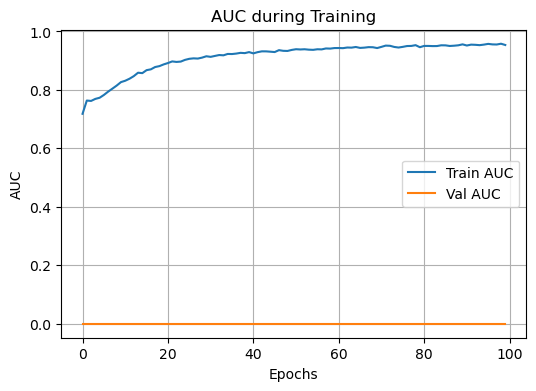

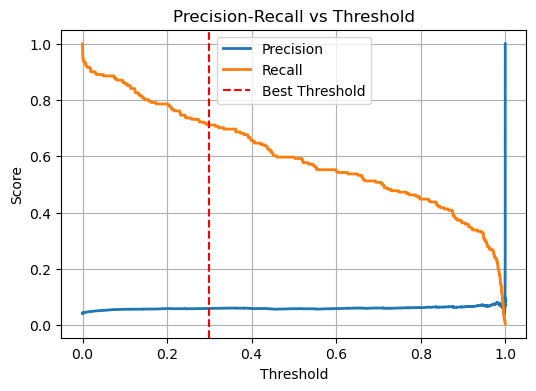

In [98]:
#  Visualization

plt.figure(figsize=(6,4))
plt.plot(history.history['AUC'], label='Train AUC')
plt.plot(history.history['val_AUC'], label='Val AUC')
plt.title("AUC during Training")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(thresholds, precision[:-1], label='Precision', linewidth=2)
plt.plot(thresholds, recall[:-1], label='Recall', linewidth=2)
plt.axvline(best_threshold, color='red', linestyle='--', label='Best Threshold')
plt.title("Precision-Recall vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


## Hyperparameter tuning with optuna

In [ ]:

# Split out a fixed validation set from the training data
X_train_tune, X_val, y_train_tune, y_val = train_test_split(
    X_train_ss, y_train_res, test_size=0.2, random_state=42, stratify=y_train_res
)

class_weight_dict = {0: 1, 1: 100}

def build_and_compile(hp):
    inputs = keras.Input(shape=(X_train_ss.shape[1],))
    x = inputs

    n_layers = hp.suggest_int("n_layers", 2, 4)
    for i in range(n_layers):
        units = hp.suggest_int(f"units_{i}", 32, 256, step=32)
        x = layers.Dense(units, activation='relu', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        dropout = hp.suggest_float(f"dropout_{i}", 0.1, 0.4)
        x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    lr = hp.suggest_loguniform("lr", 5e-4, 2e-3)
    opt = keras.optimizers.Adam(learning_rate=lr)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name="AUC")]
    )
    return model


def objective(trial):
    model = build_and_compile(trial)

    es = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=6, restore_best_weights=True
    )
    rlr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5
    )

    history = model.fit(
        X_train_tune, y_train_tune,
        validation_data=(X_val, y_val),
        epochs=60,
        batch_size=trial.suggest_categorical("batch_size", [64, 128, 256]),
        class_weight=class_weight_dict,
        callbacks=[es, rlr],
        verbose=0
    )

    # Evaluate on validation
    y_prob_val = model.predict(X_val, verbose=0).ravel()
    y_pred_val = (y_prob_val >= 0.3).astype(int)
    f1 = f1_score(y_val, y_pred_val)
    trial.report(f1, step=0)
    return f1


# Create study
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3)
)

study.optimize(objective, n_trials=40)
print("Best trial:")
print(study.best_trial.params)
print("Best F1:", study.best_trial.value)


### Getting best params and train and evaluate again with best params

In [ ]:

# Get best parameters from Optuna

# best_params = {'n_layers': 3, 'units_0': 224, 'dropout_0': 0.3435602297427919, 'units_1': 160, 'dropout_1': 0.22813197058034043, 'units_2': 192, 'dropout_2': 0.13407729978360264, 'lr': 0.0018239534612678999, 'batch_size': 64}
best_params = study.best_trial.params
print("Best parameters:", best_params)

# Build final model using best params

inputs = keras.Input(shape=(X_train_ss.shape[1],))
x = inputs

n_layers = best_params['n_layers']
for i in range(n_layers):
    units = best_params[f'units_{i}']
    x = layers.Dense(units, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    dropout = best_params[f'dropout_{i}']
    x = layers.Dropout(dropout)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)
final_model = keras.Model(inputs, outputs)

# Optimizer
lr = best_params['lr']
optimizer = keras.optimizers.Adam(learning_rate=lr)

final_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[keras.metrics.AUC(name='AUC'),
             keras.metrics.Precision(name='Precision'),
             keras.metrics.Recall(name='Recall')]
)

final_model.summary()

# Train final model on full training set

es = keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', patience=8, restore_best_weights=True)
rlr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5)

batch_size = best_params.get('batch_size', 128)
history = final_model.fit(
    X_train_ss, y_train_res,
    validation_split=0.2,
    epochs=200,
    batch_size=batch_size,
    class_weight={0:1, 1:100},
    callbacks=[es, rlr],
    verbose=2
)


Best parameters: {'n_layers': 3, 'units_0': 224, 'dropout_0': 0.3435602297427919, 'units_1': 160, 'dropout_1': 0.22813197058034043, 'units_2': 192, 'dropout_2': 0.13407729978360264, 'lr': 0.0018239534612678999, 'batch_size': 64}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 59)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 224)            │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224)            │           896 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 160)            │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 160)            │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 192)            │        30,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 192)            │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,849 (323.63 KB)

 Trainable params: 81,697 (319.13 KB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/200
356/356 - 9s - 26ms/step - AUC: 0.6991 - Precision: 0.4871 - Recall: 0.9671 - loss: 6.1174 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_loss: 0.0048 - learning_rate: 0.0018
Epoch 2/200
356/356 - 3s - 9ms/step - AUC: 0.7894 - Precision: 0.4697 - Recall: 0.9985 - loss: 2.5874 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_loss: 0.0029 - learning_rate: 0.0018
Epoch 3/200
356/356 - 3s - 9ms/step - AUC: 0.8205 - Precision: 0.4787 - Recall: 0.9988 - loss: 2.3884 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_loss: 0.0025 - learning_rate: 0.0018
Epoch 4/200
356/356 - 5s - 15ms/step - AUC: 0.8413 - Precision: 0.4795 - Recall: 0.9992 - loss: 2.3067 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_loss: 0.0033 - learning_rate: 0.0018
Epoch 5/200
356/356 - 2s - 5ms/step - AUC: 0.8552 - Precision: 0.4850 - Recall: 0.9988 - loss: 2.2184 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - 

### Model Evaluation

In [ ]:
# Predictions and Evaluation


y_prob = model.predict(X_test_ss).ravel()
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
y_pred = (y_prob >= best_threshold).astype(int)
print('Best_threshold',best_threshold)


print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Test PR-AUC:", average_precision_score(y_test, y_prob))
print('Gini :',2 * roc_auc_score(y_test, y_prob) - 1)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Best_threshold 0.94780916
Test ROC-AUC: 0.6323297250371859
Test PR-AUC: 0.06767891405105053
Gini : 0.26465945007437175
Confusion Matrix:
 [[3736  843]
 [ 135   66]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9651    0.8159    0.8843      4579
           1     0.0726    0.3284    0.1189       201

    accuracy                         0.7954      4780
   macro avg     0.5189    0.5721    0.5016      4780
weighted avg     0.9276    0.7954    0.8521      4780



Visualization

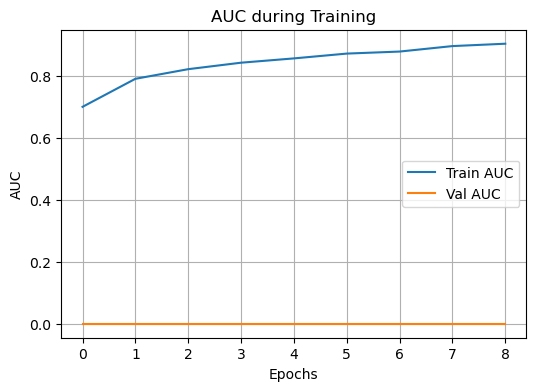

In [101]:
# Visualization: AUC during training

plt.figure(figsize=(6,4))
plt.plot(history.history['AUC'], label='Train AUC')
plt.plot(history.history['val_AUC'], label='Val AUC')
plt.title("AUC during Training")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.grid(True)
plt.show()


### Getting Top 20 important features

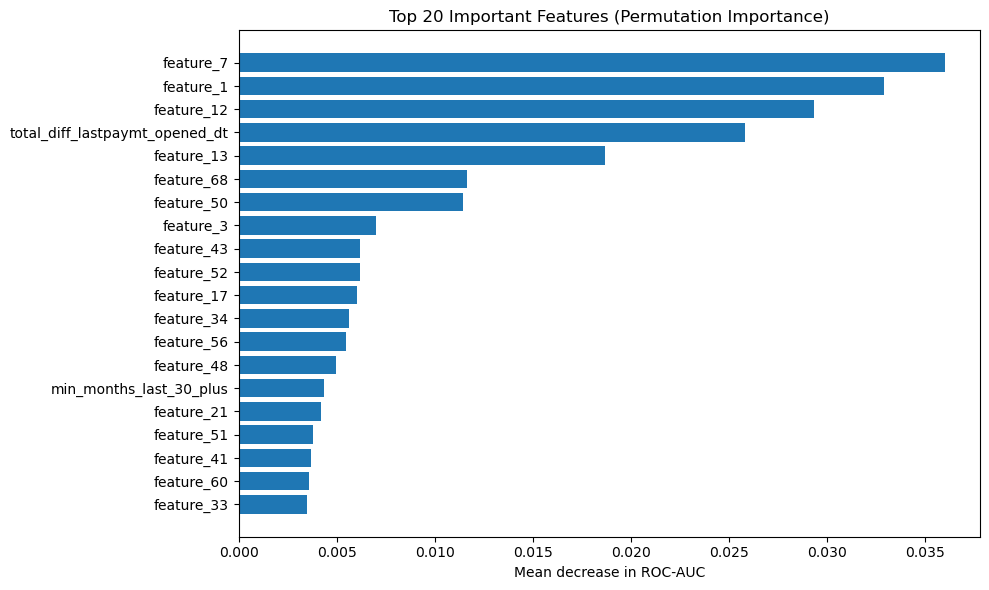

In [102]:
# Wrapper so sklearn understands Keras model
class KerasWrapper:
    def __init__(self, model):
        self.model = model
    def fit(self, X, y):
        # Dummy fit (permutation_importance never calls it)
        return self
    def predict_proba(self, X):
        y_pred = self.model.predict(X, verbose=0).ravel()
        return np.column_stack([1 - y_pred, y_pred])

wrapper = KerasWrapper(model)

# Compute permutation importance
r = permutation_importance(
    estimator=wrapper,
    X=X_test_ss,
    y=y_test,
    scoring=lambda estimator, X, y: roc_auc_score(y, estimator.predict_proba(X)[:, 1]),
    n_repeats=5,
    random_state=42
)

# Organize results
importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": r.importances_mean
}).sort_values("importance", ascending=False)

# Plot Top 20
top20 = importance_df.head(20)
plt.figure(figsize=(10,6))
plt.barh(top20["feature"][::-1], top20["importance"][::-1])
plt.title("Top 20 Important Features (Permutation Importance)")
plt.xlabel("Mean decrease in ROC-AUC")
plt.tight_layout()
plt.show()
